In [537]:
import scipy.io
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

%matplotlib inline

In [538]:
mat = scipy.io.loadmat('ECG1.mat')
mat['ECG'] = mat['ECG'].T

In [539]:
# convert to microvolts & seconds to make it easier to digest
ECG = np.array(mat['ECG'])[0] * 1000000
tECG = np.array(mat['tECG'])[0] * 60

In [540]:
print(ECG)
print(tECG)
print(ECG.shape)
print(tECG.shape)

[-761.94223948 -763.24248221 -764.07706365 ... -173.18631581 -162.94921807
 -152.81671949]
[6.55360000e-04 1.31072000e-03 1.96608000e-03 ... 7.37928937e+03
 7.37929003e+03 7.37929069e+03]
(11259904,)
(11259904,)


In [541]:
def getAdvancedDCOffset(ECG_arr):
    # we're not sure of scale of volts, so use a percentage of diff btwn. min and max instead
    scale = (max(ECG_arr) - min(ECG_arr))/1000
    # start at mean - 50*scale, so that we have 100 scales total surrounding the mean to work with
    start = ECG_arr.mean() - 50*scale
    # find the mode using a relative range
    currentHighest = 0
    currentDC = 0
    for x in range(0, 100):
        # i tried doing this using st+sc*x < ECG_arr < st+sc*(x+1) but numpy hates compound inequalities i think
        # this workaround should be equivalent, just slower

        # get elements under upper bound
        ECG_upper = ECG_arr < (start + scale*(x+1))
        # get elements above lower bound
        ECG_lower = ECG_arr > (start + scale*x)
        # apply logical and, then count
        countRangeMode = np.sum(np.logical_and(ECG_lower, ECG_upper))

        if countRangeMode > currentHighest:
            currentHighest = countRangeMode
            currentDC = start+scale*x

    return currentDC

In [542]:
def getSectionByTime(start, stop):
    new_tECG = []
    for x in tECG:
        if start <= x <= stop:
            new_tECG.append(x)
        elif x >= stop:
            break
    new_ECG = ECG[:len(new_tECG)]
    return [np.array(new_tECG), np.array(new_ECG)]

In [543]:
# cut a segment of the data by time
cut_data = getSectionByTime(2, 90)
cut_tECG = cut_data[0]
cut_ECG = cut_data[1]

#mean_ECG = cut_ECG - cut_ECG.mean()
#median_ECG = cut_ECG - np.median(cut_ECG)

# apply dc offset to ECG
cut_ECG = cut_ECG - getAdvancedDCOffset(cut_ECG)

In [544]:
# mean method
#plt.plot(cut_tECG, mean_ECG)
#plt.show()

In [545]:
# median method
#plt.plot(cut_tECG, mean_ECG)
#plt.show()

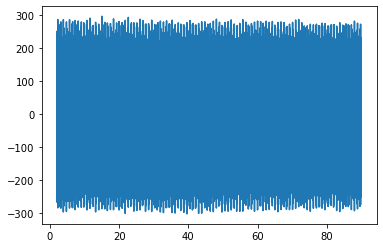

In [546]:
# "relative mode" method
plt.plot(cut_tECG, cut_ECG)
plt.show()
# THIS IS LIKE SLIGHTLY MORE EFFECTIVE THAN MEAN YUAAAAY

In [554]:
def make_circle(point, color, text, radius):

    plt.plot(point[0], point[1], 'o', ms=radius * 2, mec=color, mfc='none', mew=2)
    plt.text(point[0], point[1], text, color='black', fontsize=12)

In [548]:
# find element in sorted array that is closest to the query but still less than the query
# "less" is boolean parameter: true searches for closest less, false searches for closest greater
def find_in_arr_closest(arr, query, less):
    result = -999
    for x in arr:
        if x > query:
            if not less:
                result = x
            break
        else:
            result = x
    return result

In [549]:
# find all significant maxes/mins, only looking in data greater than a fraction of the diff btwn. max and min
peaks = signal.find_peaks(cut_ECG, (max(cut_ECG) - min(cut_ECG))/6)[0]
negatives = signal.find_peaks(cut_ECG * -1, (max(cut_ECG) - min(cut_ECG))/6)[0]

cut_ECG = abs(cut_ECG)
# note: this is kinda band-aid? doesn't work if R is negative and such idk
# very very bad fix

apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
apple sauce
appl

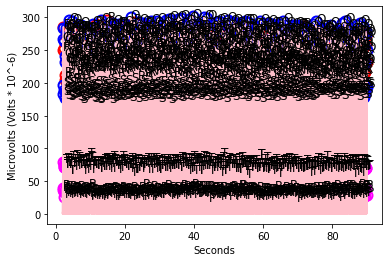

In [555]:
# these work by index in array soooo
# plot maxes

for x in peaks:
    make_circle([cut_tECG[x], cut_ECG[x]], 'red', 'R', 5)

# plot mins -- we assume they alternate between Q and S
current_wave = 'Q'
for x in negatives:
    make_circle([cut_tECG[x], cut_ECG[x]], 'blue', current_wave, 5)
    if current_wave == 'Q':
        current_wave = 'S'
    else:
        current_wave = 'Q'

# plot P wave
for x in range(0, len(peaks)):
    # find midpoint btwn this peak and next
    # for first peak, just use 0 instead
    if x == 0:
        start_index = 0
    else:
        start_index = ceil((peaks[x-1] + peaks[x])/2)
    # find the index of the local minimum closest to the left of the peak we're analyzing
    end_index = find_in_arr_closest(negatives, peaks[x], True)
    # from start index to end index, find maximum in the ECG
    if not len(signal.find_peaks(cut_ECG[start_index:end_index])[0]) == 0:
        # these 3 lines get highest peak instead of first peak
        peak_indices, peak_dict = signal.find_peaks(cut_ECG[start_index:end_index], height=0)
        peak_heights = peak_dict['peak_heights']
        p_wave = peak_indices[np.argmax(peak_heights)] + start_index
    else:
        print("apple sauce")
    # finally, plot it!
    make_circle([cut_tECG[p_wave], cut_ECG[p_wave]], 'magenta', 'P', 5)

# plot T wave
for x in range(0, len(peaks)):
    # find the index of the local minimum closest to the left of the peak we're analyzing
    start_index = find_in_arr_closest(negatives, peaks[x], False)
    # find index that is 1/4 of the way to peak 2, cuz they're rats and it short
    # special case for last wave in peaks b/c no next peak to compare to
    if x == len(peaks) - 1:
        end_index = len(cut_ECG)
    else:
        end_index = ceil(peaks[x] + (peaks[x+1] - peaks[x])/4)
    # from start index to end index, find local maximum in the ECG
    if not len(signal.find_peaks(cut_ECG[start_index:end_index])[0]) == 0:
        t_wave = signal.find_peaks(cut_ECG[start_index:end_index])[0][0] + start_index
    else:
        print("apple sauce")

    # finally, plot it!
    make_circle([cut_tECG[t_wave], cut_ECG[t_wave]], 'magenta', 'T', 5)

# SUPER HYPE PLT.SHOW() YAAAY
plt.plot(cut_tECG, cut_ECG, color='pink')
plt.xlabel('Seconds')
plt.ylabel('Microvolts (Volts * 10^-6)')
plt.show()

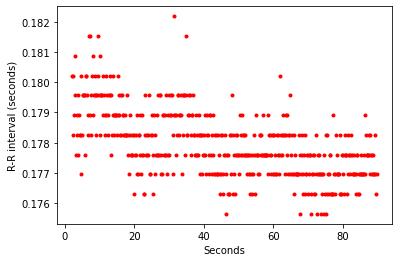

In [559]:
# graph r-r intervals
for x in range(0, len(peaks) - 1):
    make_circle([cut_tECG[peaks[x]], cut_tECG[peaks[x+1]]-cut_tECG[peaks[x]]], 'red', ' ', 1)
plt.xlabel('Seconds')
plt.ylabel('R-R interval (seconds)')
plt.show()

In [552]:
from numpy import diff
dydx = diff(cut_tECG)/diff(cut_ECG)
print(dydx)


[-0.00050403 -0.03648567  0.00278137 ... -0.00014494 -0.00017551
 -0.00020995]


C:\Users\suhny\AppData\Local\Temp\ipykernel_13556\2306318651.py:2: RuntimeWarning: divide by zero encountered in true_divide
  dydx = diff(cut_tECG)/diff(cut_ECG)


In [553]:
'''
IDEA NOTEBOOK
    - apply absolute value first b/c we don't know if any of the waves are + or -
        - this will screw with negative (Q/S) detection but just deal with it lol
        - maybe can apply absolute value after identifying Q/S and only use abs for P and T?
            - but then what if R is negative idk
    - check if signal is inverted by checking for two peaks rly close to each other? bc those would be Q and S
        - can have an alternate version
    - for coding explanations, use flowchart (w/ animated graphs?) of steps used to analyze
        - along the way, explain why it is relevant and which graph segments correspond to what parts of heart
'''

"\nIDEA NOTEBOOK\n    - apply absolute value first b/c we don't know if any of the waves are + or -\n        - this will screw with negative (Q/S) detection but just deal with it lol\n        - maybe can apply absolute value after identifying Q/S and only use abs for P and T?\n            - but then what if R is negative idk\n    - check if signal is inverted by checking for two peaks rly close to each other? bc those would be Q and S\n        - can have an alternate version\n    - for coding explanations, use flowchart (w/ animated graphs?) of steps used to analyze\n        - along the way, explain why it is relevant and which graph segments correspond to what parts of heart\n"